In [73]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transformation utilties

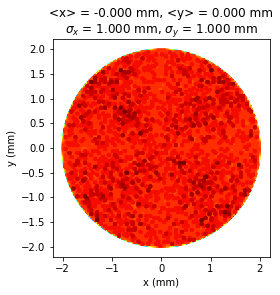

In [150]:
units = {'x':'mm','y':'mm','r':'mm','px':'keV/c','py':'keV/c','t':'ps','q':'pC'}

# Basic Beer can example using a json file:
from distgen.reader import Reader
from distgen.generator import Generator
from distgen.plot import plot_2d
from distgen.physical_constants import unit_registry as unit

# The distgen reader assumes the input file is json formatted.  If not it, it defaults to parsing the file as an ascii txt file.
filename = "data/beer.can.in.json"
par = Reader(filename,verbose=0)
p = par.read()
gen = Generator(params = p, verbose=0) # Create a generator object
beam = gen.beam()

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Translations

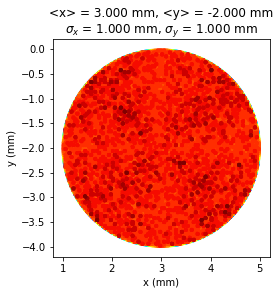

In [115]:
# Translations: a translation of a single coordinate are handled by transforms.translate
from distgen.transforms import translate

translate(beam,'x',+3*unit('mm'))
translate(beam,'y',-2*unit('mm'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Scaling

Basic scaling is handled using transforms.scale.  To scale the $x$ coordinate of the beam by $\alpha$ use:

scale(beam,'x',$\alpha$) 

where $\alpha$ is a dimensionless quantity or float.  Note that if the $<x>\neq0$ then 
$<x>\rightarrow\alpha<x>$.  It is possible to fix the average value under scaling using:

scale(beam,'x',$\alpha$, fix_average='True') 


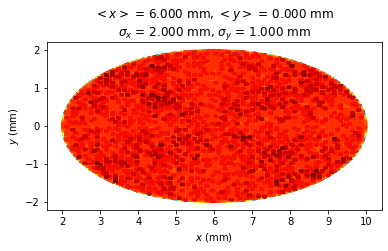

In [217]:
from distgen.transforms import scale
beam = gen.beam()
translate(beam,'x',3*unit('mm'))

scale(beam,'x',2)

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

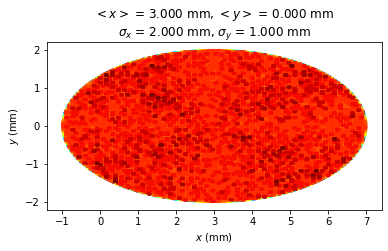

In [218]:
beam = gen.beam()
translate(beam,'x',3*unit('mm'))

scale(beam,'x',2,fix_average=True)

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Shift and Scale a single coordinate

It is possible to combine a translation with a scaling operation to shift and rescale a coordinate
to have a new standard deviation while keeping the form of the underlying coordinate distribution unchanged. This is accomplished using transforms.set_avg_and_std(...)

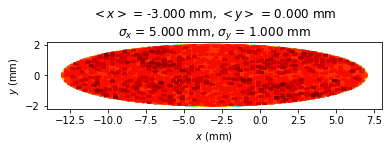

In [219]:
from distgen.transforms import set_avg_and_std
beam = gen.beam()

set_avg_and_std(beam,'x',-3*unit('mm'),5*unit('mm'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Rotating coordinates

Rotation between two coordinates is accomplished using transforms.rotate2d.  In addition to the beam 
object, the user must specify the variables to rotate.  This can be done in a string of the form 'var1:var2' or as a list of strs ['var1','var2'].  The variables supplied must have the same type of units.  The user must also specify an angle in radians or degrees to rotate by. 

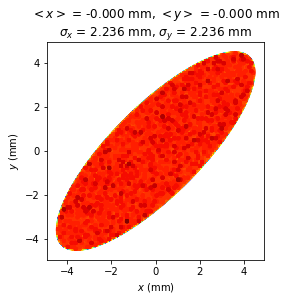

In [220]:
from distgen.transforms import rotate2d
beam = gen.beam()
scale(beam,'x',3.0)

rotate2d(beam, 'x:y', 45*unit('deg'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");


Note, the default behavior is to rotate around the coordinate origins (not the coordinate averages):

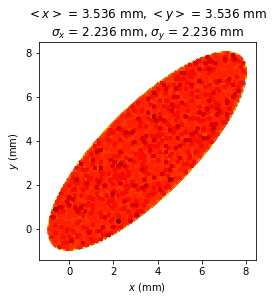

In [173]:
beam = gen.beam()
scale(beam,'x',3.0)
translate(beam,'x',5*unit('mm'))

rotate2d(beam, 'x:y', 45*unit('deg'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

The rotation can be performed about a different origin by setting the keyword arguement 'origin'.  Often it is desirable to set the origin of rotation to be the coordinate centroids. This is done by setting origin='centroid':

5.0 millimeter 1.0436096431476471e-19 meter


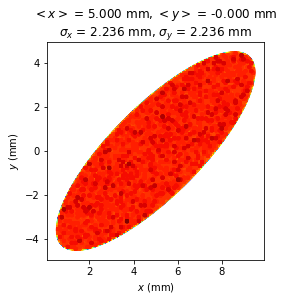

In [170]:
beam = gen.beam()
scale(beam,'x',3.0)
translate(beam,'x',5*unit('mm'))

rotate2d(beam, 'x:y', 45*unit('deg'), origin='centroid')

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Sheer

The sheer operation allows one to apply a sheer in a 2D subspace according of the form:

$v\rightarrow v + \alpha u$

This can be useful in a variety of cases such as drifting particles or applying magnetization as shown below.  Here the magnetization 
$\mathcal{L}$
is added to the particle momentum in the form
$p_x\rightarrow p_x + \frac{\mathcal{L}}{\sigma_{x,y}^2}y$
and $p_y\rightarrow p_y - \frac{\mathcal{L}}{\sigma_{x,y}^2}x$.  This results in a transverse emittance of
$\sqrt{\epsilon_{n,x,uncor}^2 + \mathcal{L}^2}$


% error in magnetization  1.2103734493580161e-05 dimensionless


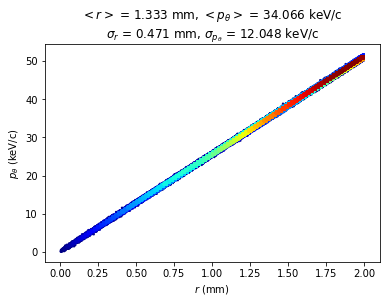

In [216]:
from distgen.physical_constants import MC2
import numpy as np
from distgen.transforms import sheer
beam = gen.beam()

xemitt_uncorrelated = beam.emitt('x')

Lmag = -50*unit('micrometers')*MC2.magnitude*unit("eV/c")
sheer_coefficient = Lmag/beam.std('y')/beam.std('y')

sheer(beam,'y:px',+sheer_coefficient)
sheer(beam,'x:py',-sheer_coefficient)

xemitt = beam.emitt('x')

print('% error in magnetization ', 100*(xemitt - np.sqrt(xemitt_uncorrelated**2 + Lmag**2) )/xemitt )

plot_2d(beam,1,"r",units["r"],"ptheta",units["px"],'scatter_hist2d',nbins=100);